### Import libraries and sub-libraries

In [98]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import math
import random
import traceback

### Font setting

In [99]:
try:
    from fontsetting import font_cmu
    plt = font_cmu(plt)
except ImportError:
    print("Custom font setting 'fontsetting.py' not found. Using default fonts.")
    pass

### Configuration & Hyperparameters

In [100]:
# Data Paths
TRAIN_HIGH_RES_DIR = 'data/train/high-res'
TRAIN_LOW_RES_DIR = 'data/train/low-res'
VAL_HIGH_RES_DIR = 'data/val/high-res'
VAL_LOW_RES_DIR = 'data/val/low-res'

# Model Saving
MODEL_SAVE_PATH = 'best_model.pth'

# Training Settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
# Weight for the SSIM component in the combined loss (1.0 means only SSIM loss, 0.0 means only MSE loss)
LOSS_ALPHA = 0.5 # Example: Equal weight to MSE and (1-SSIM)

print(f'Device available: {DEVICE}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Number of Epochs: {NUM_EPOCHS}')
print(f'Loss Alpha (Weight for 1-SSIM): {LOSS_ALPHA}')

# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Device available: cuda
Batch Size: 1
Learning Rate: 1e-05
Number of Epochs: 5
Loss Alpha (Weight for 1-SSIM): 0.5


### Data Loading and Transformations

In [101]:
# Custom transform class to apply augmentation identically to low-res and high-res pairs
class PairTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, low_res_tensor, high_res_tensor): # Now receives tensors
        # REMOVED: TF.to_tensor calls are no longer needed here

        # Apply augmentations that need consistency
        if isinstance(self.transform, transforms.Compose):
            for t in self.transform.transforms:
                 # Example: Apply RandomHorizontalFlip identically
                if isinstance(t, transforms.RandomHorizontalFlip):
                    if random.random() < 0.5: # Manually apply based on probability
                       low_res_tensor = TF.hflip(low_res_tensor)
                       high_res_tensor = TF.hflip(high_res_tensor)
                # Example: Apply RandomRotation identically
                elif isinstance(t, transforms.RandomRotation):
                    # Ensure angle generation is compatible if needed, or use tensor rotation directly
                    angle = transforms.RandomRotation.get_params(t.degrees)
                    low_res_tensor = TF.rotate(low_res_tensor, angle)
                    high_res_tensor = TF.rotate(high_res_tensor, angle)
                # Apply other transforms individually if needed (or ensure they handle pairs)
                else:
                     pass # Add handling for other transforms if needed

        # Apply remaining transforms from Compose if any (e.g., Normalize, if needed)
        # This part needs careful implementation based on specific transforms used

        return low_res_tensor, high_res_tensor

class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, pair_transform=None, individual_transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.pair_transform = pair_transform
        self.individual_transform = individual_transform # For transforms applied after pair transforms, like ToTensor if not handled above

        try:
            self.high_res_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
            self.low_res_filenames = sorted([f for f in os.listdir(low_res_dir) if f.endswith('.tif')])
        except FileNotFoundError as e:
            print(f"Error: Directory not found - {e}. Please check data paths.")
            raise

        # Ensure filenames match - simple check based on counts and names
        if len(self.high_res_filenames) != len(self.low_res_filenames):
            raise ValueError("Mismatch in number of high-res and low-res files.")
        if self.high_res_filenames != self.low_res_filenames:
            print("Warning: File names in high-res and low-res directories do not perfectly match. Assuming correspondence by sorted order.")
        self.filenames = self.high_res_filenames # Use one list assuming correspondence

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        try:
            # Load images using PIL
            high_res_img_pil = Image.open(high_res_path)
            low_res_img_pil = Image.open(low_res_path)

            # --- Handle High-Res Image ---
            # Convert PIL image (potentially mode 'F') to NumPy array
            high_res_np = np.array(high_res_img_pil, dtype=np.float32) # Ensure float32

            # Optional: Print raw float range (for debugging if needed)
            # print(f"Debug idx {idx} High-Res RAW float stats: Min={high_res_np.min():.4f}, Max={high_res_np.max():.4f}")

            # Scale float NumPy array to [0.0, 1.0] range
            min_val_hr = high_res_np.min()
            max_val_hr = high_res_np.max()
            if max_val_hr > min_val_hr:  # Avoid division by zero if image is constant
                high_res_np = (high_res_np - min_val_hr) / (max_val_hr - min_val_hr)
            else:
                high_res_np = np.zeros_like(high_res_np) # Or handle constant image as needed

            # Convert scaled NumPy array to PyTorch float tensor
            # Add channel dimension (C, H, W) - PyTorch expects channels first
            high_res_tensor = torch.from_numpy(high_res_np).unsqueeze(0).float()


            # --- Handle Low-Res Image ---
            # Ensure low-res is resized *before* converting to float array if needed
            low_res_img_pil = low_res_img_pil.resize((128, 128), Image.BICUBIC)
            low_res_np = np.array(low_res_img_pil, dtype=np.float32) # Ensure float32

            # Optional: Print raw float range
            # print(f"Debug idx {idx} Low-Res RAW float stats: Min={low_res_np.min():.4f}, Max={low_res_np.max():.4f}")

            # Scale float NumPy array to [0.0, 1.0] range
            min_val_lr = low_res_np.min()
            max_val_lr = low_res_np.max()
            if max_val_lr > min_val_lr:
                low_res_np = (low_res_np - min_val_lr) / (max_val_lr - min_val_lr)
            else:
                low_res_np = np.zeros_like(low_res_np)

            # Convert scaled NumPy array to PyTorch float tensor
            # Add channel dimension (C, H, W)
            low_res_tensor = torch.from_numpy(low_res_np).unsqueeze(0).float()


        except FileNotFoundError:
            print(f"Error: File not found for index {idx}. Paths: {high_res_path}, {low_res_path}")
            return None, None
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            traceback.print_exc()
            return None, None


        # Apply transformations (PairTransform now receives Tensors)
        if self.pair_transform:
            # NOTE: PairTransform needs to handle tensors now, not PIL images
            low_res_tensor, high_res_tensor = self.pair_transform(low_res_tensor, high_res_tensor)

        # Individual transforms (if any, applied after pair transform)
        if self.individual_transform:
            low_res_tensor = self.individual_transform(low_res_tensor)
            high_res_tensor = self.individual_transform(high_res_tensor)


        # Ensure high-res size is correct *after* potential transforms
        # (Resize might be better done before tensor conversion or carefully within transforms)
        # For now, assuming transforms don't change size from 256x256
        # target_size = (256, 256)
        # if high_res_tensor.shape[1:] != target_size:
        #      high_res_tensor = TF.resize(high_res_tensor, target_size, interpolation=transforms.InterpolationMode.BICUBIC)


        return low_res_tensor, high_res_tensor # Return the correctly scaled tensors    

# Define transformations
# Training transforms: include augmentation
train_pair_transform = PairTransform(
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), # Example: Random rotation up to 15 degrees
        # Add other desired augmentations here
    ])
)
# Using only ToTensor for validation/testing (applied within PairTransform or Dataset __getitem__)
val_pair_transform = PairTransform(transforms.Compose([])) # No augmentation for validation

# Datasets
try:
    train_dataset = TIFFDataset(
        high_res_dir=TRAIN_HIGH_RES_DIR,
        low_res_dir=TRAIN_LOW_RES_DIR,
        pair_transform=train_pair_transform
    )
    val_dataset = TIFFDataset(
        high_res_dir=VAL_HIGH_RES_DIR,
        low_res_dir=VAL_LOW_RES_DIR,
        pair_transform=val_pair_transform # Use non-augmenting transform for validation
    )
except Exception as e:
     print(f"Failed to create datasets: {e}")
     # Exit or handle error appropriately
     exit()


# DataLoaders
# TODO: Fix error with num_workers > 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # No shuffle for validation

print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')

Number of training images: 240
Number of validation images: 30


### Evaluation Metrics Implementation

In [102]:
# Manual PSNR calculation (assuming max pixel value of 1.0 for normalized data)
def psnr(target, output, max_val=1.0):
    mse = F.mse_loss(output, target)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse))

# SSIM metric using torchmetrics
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE) # data_range=1.0 for normalized images

# Combined Score Calculation
def calculate_score(psnr_val, ssim_val):
    return psnr_val + 40 * ssim_val

# Helper to calculate metrics for a batch
def calculate_metrics(output, target):
    # Ensure tensors are on the correct device and detached
    output = output.detach()
    target = target.detach()

    # Clamp output to valid range [0, 1] before metric calculation
    output = torch.clamp(output, 0.0, 1.0)

    # Calculate PSNR per image in batch and average
    batch_psnr = 0
    for i in range(output.shape[0]):
        batch_psnr += psnr(target[i], output[i])
    avg_psnr = batch_psnr / output.shape[0]

    # Calculate SSIM for the batch (torchmetrics handles batch)
    # Ensure batch dim exists, add if needed
    if output.dim() == 3: output = output.unsqueeze(0)
    if target.dim() == 3: target = target.unsqueeze(0)

    # Ensure C, H, W format if needed by ssim_metric (torchmetrics expects NCHW or NHWC)
    # Assuming NCHW from DataLoader
    avg_ssim = ssim_metric(output, target).item() # .item() to get scalar value

    # Calculate combined score
    score = calculate_score(avg_psnr, avg_ssim)

    return avg_psnr, avg_ssim, score

### Super-Resolution Network Definition (TrivialNet)

In [103]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        # Input: 1x256x256 (after interpolation)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)
        # No activation, simple linear filtering [cite: 7]

    def forward(self, x):
        # x expected to be N x 1 x 256 x 256
        x = self.conv1(x)
        x = self.conv2(x)
        return x

### Loss Function Definition

In [104]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, data_range=1.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha # Weight for SSIM loss component
        self.mse_loss = nn.MSELoss()
        # Use the same SSIM metric instance or create a new one for loss calculation
        self.ssim_loss_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(DEVICE)
        print(f"CombinedLoss initialized with alpha={alpha} (weight for 1-SSIM loss)")

    def forward(self, output, target):
        # Clamp output for SSIM calculation stability
        output_clamped = torch.clamp(output, 0.0, 1.0)

        mse = self.mse_loss(output, target) # Use original output for MSE

        # Calculate SSIM - ensure NCHW format
        # Ensure batch dim exists
        if output_clamped.dim() == 3: output_clamped = output_clamped.unsqueeze(0)
        if target.dim() == 3: target = target.unsqueeze(0)

        ssim_val = self.ssim_loss_metric(output_clamped, target)

        # SSIM loss: 1 - SSIM (since SSIM is maximized, loss is minimized)
        ssim_loss = 1.0 - ssim_val

        # Combine losses
        combined_loss = (1 - self.alpha) * mse + self.alpha * ssim_loss
        return combined_loss

### Training and Validation Functions

In [105]:
# Function for one training epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    processed_batches = 0
    for i, (low_res_batch, high_res_batch) in enumerate(loader):
        # Filter out None values if dataset __getitem__ returned None due to errors
        if low_res_batch is None or high_res_batch is None:
             print(f"Skipping batch {i} due to loading error.")
             continue

        low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)

        # Upsample low-resolution input to target size (256x256)
        # Using align_corners=False is generally recommended for scale factors > 1
        low_res_interpolated = F.interpolate(low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

        optimizer.zero_grad()
        super_res_batch = model(low_res_interpolated) # Forward pass
        loss = criterion(super_res_batch, high_res_batch) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        total_loss += loss.item()
        processed_batches += 1

        if (i + 1) % 20 == 0: # Print loss every 20 iterations
             print(f'    Iteration {i+1}/{len(loader)}, Loss: {loss.item():.6f}')

    if processed_batches == 0: return 0.0 # Avoid division by zero if all batches failed
    avg_loss = total_loss / processed_batches
    return avg_loss


# Function for validation
def validate_model(model, loader, criterion):
    model.eval()
    total_val_loss = 0
    total_psnr = 0
    total_ssim = 0
    total_score = 0
    processed_batches = 0

    with torch.no_grad():
        for i, (low_res_batch, high_res_batch) in enumerate(loader):
            if low_res_batch is None or high_res_batch is None:
                 print(f"Skipping validation batch {i} due to loading error.")
                 continue

            low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)

            # Upsample low-resolution input
            low_res_interpolated = F.interpolate(low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

            super_res_batch = model(low_res_interpolated)
            loss = criterion(super_res_batch, high_res_batch)
            total_val_loss += loss.item()

            # Calculate metrics for the batch
            batch_psnr, batch_ssim, batch_score = calculate_metrics(super_res_batch, high_res_batch)
            total_psnr += batch_psnr * low_res_batch.size(0) # Weight by batch size
            total_ssim += batch_ssim * low_res_batch.size(0)
            total_score += batch_score * low_res_batch.size(0)
            processed_batches += low_res_batch.size(0) # Count total samples processed


    if processed_batches == 0: return 0.0, 0.0, 0.0, 0.0 # Avoid division by zero

    avg_val_loss = total_val_loss / len(loader) # Loss averaged over batches
    avg_psnr = total_psnr / processed_batches
    avg_ssim = total_ssim / processed_batches
    avg_score = total_score / processed_batches

    return avg_val_loss, avg_psnr, avg_ssim, avg_score


# Main training loop function
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, model_save_path):
    train_losses = []
    val_losses = []
    val_scores = []
    best_val_score = -float('inf') # Initialize with negative infinity for maximization

    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        avg_train_loss = train_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        print(f'  Average Training Loss: {avg_train_loss:.6f}')

        # Validation phase
        avg_val_loss, avg_psnr, avg_ssim, avg_score = validate_model(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_scores.append(avg_score)
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        print(f'  Validation PSNR: {avg_psnr:.2f} dB')
        print(f'  Validation SSIM: {avg_ssim:.4f}')
        print(f'  Validation Score (PSNR + 40*SSIM): {avg_score:.4f}')

        # Save model if validation score improves
        if avg_score > best_val_score:
            best_val_score = avg_score
            torch.save(model.state_dict(), model_save_path)
            print(f'  ** New best validation score! Model saved to {model_save_path} **')

    print("\n--- Training Complete ---")
    print(f"Best Validation Score achieved: {best_val_score:.4f}")

    # Plot training and validation metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color=color, linestyle='--')
    ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle=':', linewidth=0.5)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Validation Score (PSNR + 40*SSIM)', color=color)
    ax2.plot(range(1, num_epochs + 1), val_scores, label='Validation Score', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training/Validation Loss and Validation Score')
    plt.show()

### Initialize and Train the Model

CombinedLoss initialized with alpha=0.5 (weight for 1-SSIM loss)

--- Starting Training ---

Epoch 1/5
    Iteration 20/240, Loss: 0.519055
    Iteration 40/240, Loss: 0.471965
    Iteration 60/240, Loss: 0.437114
    Iteration 80/240, Loss: 0.446165
    Iteration 100/240, Loss: 0.443206
    Iteration 120/240, Loss: 0.437064
    Iteration 140/240, Loss: 0.461939
    Iteration 160/240, Loss: 0.477444
    Iteration 180/240, Loss: 0.457068
    Iteration 200/240, Loss: 0.435240
    Iteration 220/240, Loss: 0.415806
    Iteration 240/240, Loss: 0.477636
  Average Training Loss: 0.451420
  Validation Loss: 0.417448
  Validation PSNR: 12.98 dB
  Validation SSIM: 0.2170
  Validation Score (PSNR + 40*SSIM): 21.6593
  ** New best validation score! Model saved to best_model.pth **

Epoch 2/5
    Iteration 20/240, Loss: 0.469462
    Iteration 40/240, Loss: 0.393690
    Iteration 60/240, Loss: 0.375440
    Iteration 80/240, Loss: 0.366037
    Iteration 100/240, Loss: 0.387033
    Iteration 120/240,

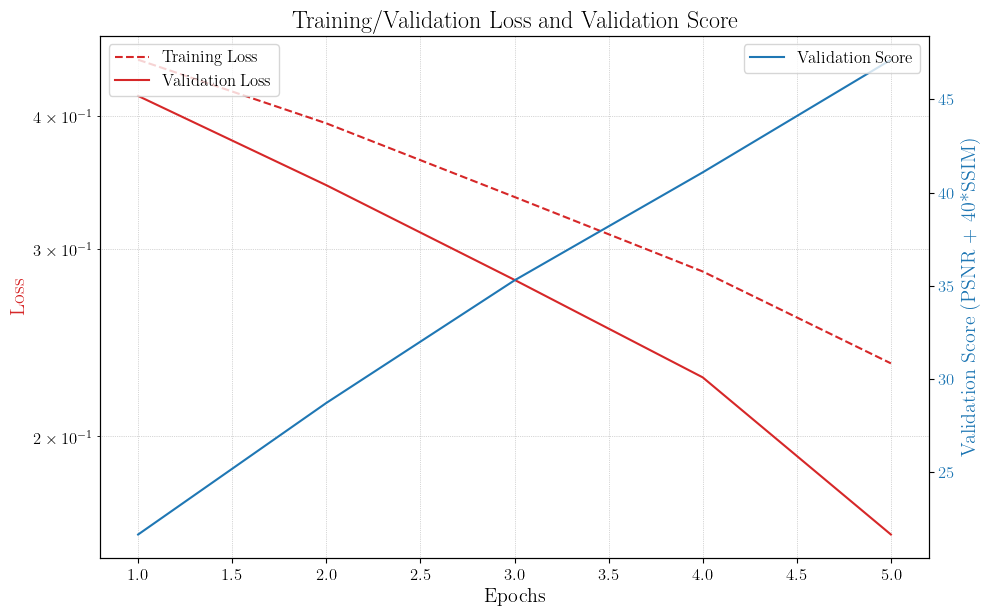

In [106]:
# Model
model = TrivialNet().to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss Function (Criterion)
criterion = CombinedLoss(alpha=LOSS_ALPHA, data_range=1.0).to(DEVICE) # Use combined loss

# Train the model
train_model(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS, MODEL_SAVE_PATH)

### Evaluate the Best Model on a Validation Image Example


--- Evaluating Best Model on Example Validation Image ---
Loaded best model weights from best_model.pth
Debug: val_high_res tensor stats: Min=0.0000, Max=1.0000, Mean=0.1564

Metrics for Example Image:
  PSNR: 19.46 dB
  SSIM: 0.5208
  Score (PSNR + 40*SSIM): 40.2959

--- Debug: Image Array Stats ---
Ground Truth (High-Res):  Min=0.0000, Max=1.0000, Mean=0.1564
Interpolated (Low-Res):   Min=-0.0146, Max=1.0111, Mean=0.1769
Super-Resolved:          Min=-0.0230, Max=0.5044, Mean=0.1105


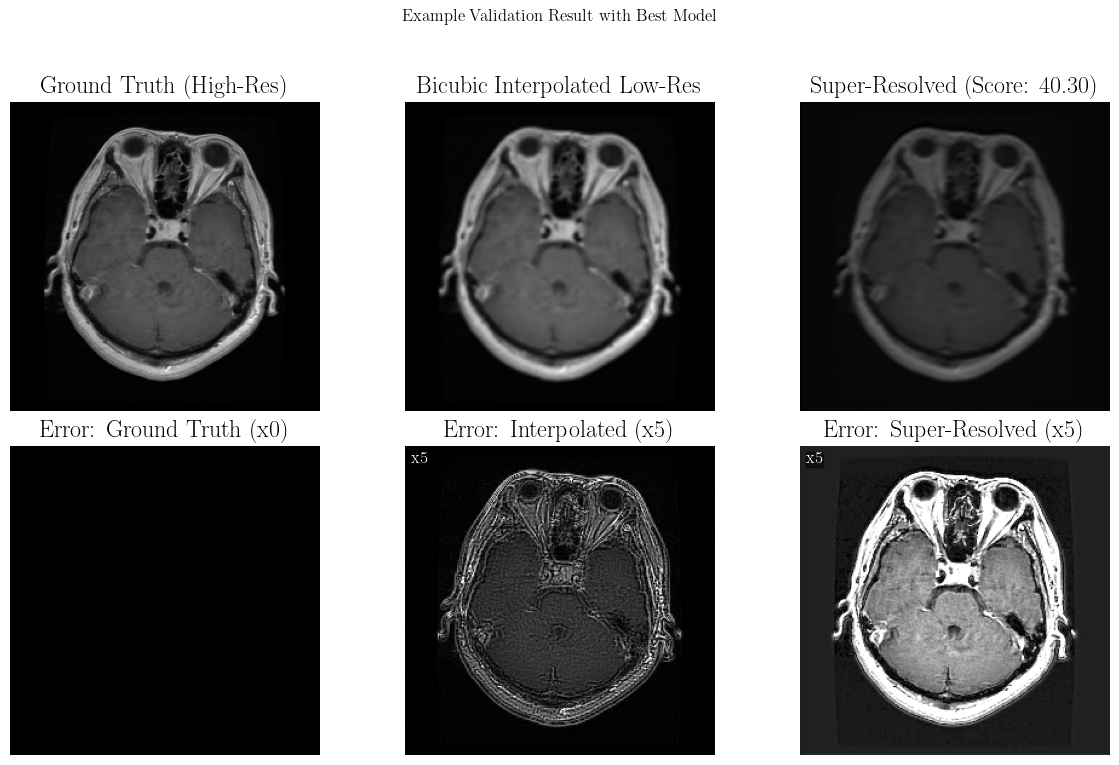

In [107]:
print("\n--- Evaluating Best Model on Example Validation Image ---")

# Load the best model weights
best_model = TrivialNet().to(DEVICE)
try:
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    best_model.eval()
    print(f"Loaded best model weights from {MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Best model file '{MODEL_SAVE_PATH}' not found. Skipping example evaluation.")
    best_model = model # Fallback to the last state if file not found (less ideal)
except Exception as e:
     print(f"Error loading model weights: {e}. Skipping example evaluation.")
     best_model = model


# Load one validation image pair
try:
    val_low_res, val_high_res = val_dataset[0] # Get the second image pair [cite: 14]
    val_low_res, val_high_res = val_low_res.to(DEVICE), val_high_res.to(DEVICE)

    print(f"Debug: val_high_res tensor stats: Min={torch.min(val_high_res):.4f}, Max={torch.max(val_high_res):.4f}, Mean={torch.mean(val_high_res):.4f}")

    # Prepare inputs (add batch dim, interpolate low-res)
    val_low_res_batch = val_low_res.unsqueeze(0)
    val_high_res_batch = val_high_res.unsqueeze(0)
    val_low_res_interpolated = F.interpolate(val_low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

    # Apply the best model
    with torch.no_grad():
        val_super_res_batch = best_model(val_low_res_interpolated)

    # Calculate metrics for this example
    ex_psnr, ex_ssim, ex_score = calculate_metrics(val_super_res_batch, val_high_res_batch)
    print(f"\nMetrics for Example Image:")
    print(f"  PSNR: {ex_psnr:.2f} dB")
    print(f"  SSIM: {ex_ssim:.4f}")
    print(f"  Score (PSNR + 40*SSIM): {ex_score:.4f}")


    # Convert tensors to numpy for visualization (move to CPU first)
    val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()
    val_high_res_np = val_high_res_batch.squeeze().cpu().numpy()
    val_super_res_np = val_super_res_batch.squeeze().cpu().numpy()

    print("\n--- Debug: Image Array Stats ---")
    print(f"Ground Truth (High-Res):  Min={np.min(val_high_res_np):.4f}, Max={np.max(val_high_res_np):.4f}, Mean={np.mean(val_high_res_np):.4f}")
    print(f"Interpolated (Low-Res):   Min={np.min(val_low_res_np):.4f}, Max={np.max(val_low_res_np):.4f}, Mean={np.mean(val_low_res_np):.4f}")
    print(f"Super-Resolved:          Min={np.min(val_super_res_np):.4f}, Max={np.max(val_super_res_np):.4f}, Mean={np.mean(val_super_res_np):.4f}")

    # Plotting (similar to original code)
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Example Validation Result with Best Model")

    # Plot images
    im_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
    ax[0, 0].imshow(val_high_res_np, **im_opts)
    ax[0, 0].set_title('Ground Truth (High-Res)')
    ax[0, 0].axis('off')

    ax[0, 1].imshow(val_low_res_np, **im_opts)
    ax[0, 1].set_title('Bicubic Interpolated Low-Res') # Changed title for clarity
    ax[0, 1].axis('off')

    ax[0, 2].imshow(val_super_res_np, **im_opts)
    ax[0, 2].set_title(f'Super-Resolved (Score: {ex_score:.2f})')
    ax[0, 2].axis('off')

    # Error maps (scaled by 5x as before)
    err_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1} # Error map vmax might need adjustment
    err_scale = 5
    ax[1, 0].imshow(err_scale * np.abs(val_high_res_np - val_high_res_np), **err_opts)
    ax[1, 0].set_title('Error: Ground Truth (x0)')
    ax[1, 0].axis('off')

    ax[1, 1].imshow(err_scale * np.abs(val_high_res_np - val_low_res_np), **err_opts)
    ax[1, 1].set_title(f'Error: Interpolated (x{err_scale})')
    ax[1, 1].axis('off')
    ax[1, 1].text(0.02, 0.98, f'x{err_scale}', transform=ax[1, 1].transAxes, fontsize=12, va='top', ha='left', color='white', bbox=dict(facecolor='black', alpha=0.5, pad=0.1))

    ax[1, 2].imshow(err_scale * np.abs(val_high_res_np - val_super_res_np), **err_opts)
    ax[1, 2].set_title(f'Error: Super-Resolved (x{err_scale})')
    ax[1, 2].axis('off')
    ax[1, 2].text(0.02, 0.98, f'x{err_scale}', transform=ax[1, 2].transAxes, fontsize=12, va='top', ha='left', color='white', bbox=dict(facecolor='black', alpha=0.5, pad=0.1))


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

except IndexError:
     print("Error: Not enough images in validation dataset to display example index 1.")
except Exception as e:
     print(f"An error occurred during example evaluation visualization: {e}")

### Final Evaluation on Full Validation Set with Best Model

In [108]:
print("\n--- Evaluating Best Model on Full Validation Set ---")

# Ensure the best model is loaded and in eval mode
if 'best_model' in locals() and isinstance(best_model, nn.Module):
    best_model.eval()
    # Recalculate metrics using the dedicated validation function
    final_val_loss, final_psnr, final_ssim, final_score = validate_model(best_model, val_loader, criterion)

    print(f"\nFinal Metrics using Best Model on Validation Set:")
    print(f"  Average PSNR: {final_psnr:.2f} dB")
    print(f"  Average SSIM: {final_ssim:.4f}")
    print(f"  Average Score (PSNR + 40*SSIM): {final_score:.4f}")
    print(f"  Average Validation Loss: {final_val_loss:.6f}")

    # Compare with simple interpolation (using the first batch for simplicity or recalculate fully)
    print("\nFor Reference (metrics for simple Bicubic Interpolation):")
    # Get one batch from validation loader to calculate interpolation metrics
    try:
        low_res_batch_ref, high_res_batch_ref = next(iter(val_loader))
        low_res_batch_ref, high_res_batch_ref = low_res_batch_ref.to(DEVICE), high_res_batch_ref.to(DEVICE)
        low_res_interpolated_ref = F.interpolate(low_res_batch_ref, scale_factor=2, mode='bicubic', align_corners=False)
        ref_psnr, ref_ssim, ref_score = calculate_metrics(low_res_interpolated_ref, high_res_batch_ref)
        print(f"  Interpolation PSNR (sample batch): {ref_psnr:.2f} dB")
        print(f"  Interpolation SSIM (sample batch): {ref_ssim:.4f}")
        print(f"  Interpolation Score (sample batch): {ref_score:.4f}")
    except StopIteration:
        print("Could not get a batch from validation loader to calculate reference interpolation metrics.")
    except Exception as e:
         print(f"Error calculating reference interpolation metrics: {e}")

else:
    print("Best model not available for final evaluation.")

print("\n--- Script End ---")


--- Evaluating Best Model on Full Validation Set ---

Final Metrics using Best Model on Validation Set:
  Average PSNR: 19.61 dB
  Average SSIM: 0.6880
  Average Score (PSNR + 40*SSIM): 47.1298
  Average Validation Loss: 0.161752

For Reference (metrics for simple Bicubic Interpolation):
  Interpolation PSNR (sample batch): 28.18 dB
  Interpolation SSIM (sample batch): 0.9370
  Interpolation Score (sample batch): 65.6559

--- Script End ---
